In [1]:
import matplotlib.pyplot as graph
import numpy as np
from numpy import fft
import math
import cv2

In [2]:
# 仿真运动模糊
def motion_process(image_size,motion_angle):
 PSF = np.zeros(image_size)
 print(image_size)
 center_position=(image_size[0]-1)/2
 print(center_position)
  
 slope_tan=math.tan(motion_angle*math.pi/180)
 slope_cot=1/slope_tan
 if slope_tan<=1:
  for i in range(15):
   offset=round(i*slope_tan) #((center_position-i)*slope_tan)
   PSF[int(center_position+offset),int(center_position-offset)]=1
  return PSF / PSF.sum() #对点扩散函数进行归一化亮度
 else:
  for i in range(15):
   offset=round(i*slope_cot)
   PSF[int(center_position-offset),int(center_position+offset)]=1
  return PSF / PSF.sum()
  

In [3]:
#对图片进行运动模糊
def make_blurred(input, PSF, eps):
 input_fft = fft.fft2(input)# 进行二维数组的傅里叶变换
 PSF_fft = fft.fft2(PSF)+ eps
 blurred = fft.ifft2(input_fft * PSF_fft)
 blurred = np.abs(fft.fftshift(blurred))
 return blurred

In [4]:
def inverse(input, PSF, eps):  # 逆滤波
 input_fft = fft.fft2(input)
 PSF_fft = fft.fft2(PSF) + eps #噪声功率，这是已知的，考虑epsilon
 result = fft.ifft2(input_fft / PSF_fft) #计算F(u,v)的傅里叶反变换
 result = np.abs(fft.fftshift(result))
 return result

In [5]:
def wiener(input,PSF,eps,K=0.01):  #维纳滤波，K=0.01
 input_fft=fft.fft2(input)
 PSF_fft=fft.fft2(PSF) +eps
 PSF_fft_1=np.conj(PSF_fft) /(np.abs(PSF_fft)**2 + K)
 result=fft.ifft2(input_fft * PSF_fft_1)
 result=np.abs(fft.fftshift(result))
 return result

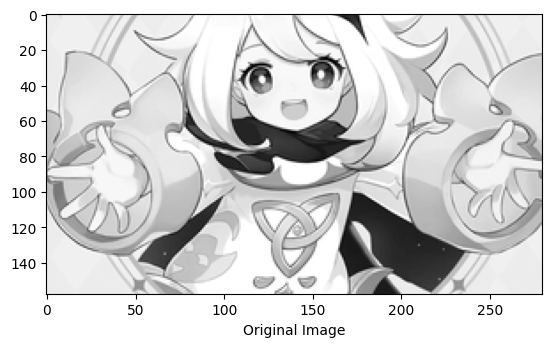

In [7]:
image = cv2.imread('.\source\paimen.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
img_h=image.shape[0]
img_w=image.shape[1]
graph.figure(1)
graph.xlabel("Original Image")
graph.gray()
graph.imshow(image)  #显示原图像

In [8]:
graph.figure(2)
graph.gray()
#进行运动模糊处理
PSF = motion_process((img_h,img_w), 60)
blurred = np.abs(make_blurred(image, PSF, 1e-3))

(158, 280)
78.5


<Figure size 640x480 with 0 Axes>

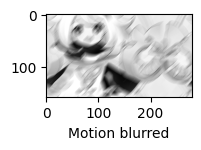

In [9]:
graph.subplot(231)
graph.xlabel("Motion blurred")
graph.imshow(blurred)
  

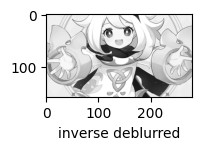

In [10]:
result = inverse(blurred, PSF, 1e-3) #逆滤波
graph.subplot(232)
graph.xlabel("inverse deblurred")
graph.imshow(result)

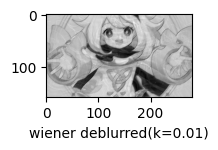

In [11]:
result=wiener(blurred,PSF,1e-3)  #维纳滤波
graph.subplot(233)
graph.xlabel("wiener deblurred(k=0.01)")
graph.imshow(result)

In [12]:
blurred_noisy=blurred + 0.1 * blurred.std() * \
   np.random.standard_normal(blurred.shape) #添加噪声,standard_normal产生随机的函数

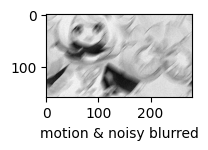

In [13]:
graph.subplot(234)
graph.xlabel("motion & noisy blurred")
graph.imshow(blurred_noisy)  #显示添加噪声且运动模糊的图像

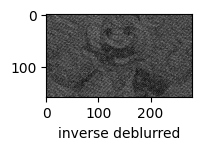

In [14]:
result = inverse(blurred_noisy, PSF, 0.1+1e-3) #对添加噪声的图像进行逆滤波
graph.subplot(235)
graph.xlabel("inverse deblurred")
graph.imshow(result)

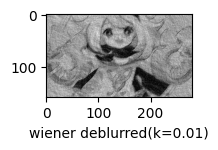

In [15]:
result=wiener(blurred_noisy,PSF,0.1+1e-3)   #对添加噪声的图像进行维纳滤波
graph.subplot(236)
graph.xlabel("wiener deblurred(k=0.01)")
graph.imshow(result)

In [16]:
graph.show()